In [43]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from math import floor

Cài đặt hàm lấy mẫu tín hiệu theo nhãn trong tập tín hiệu huấn luyện

In [44]:

def signal_filter(file_name_lab, file_name_wav, filter):
    result = []
    file = open(file_name_lab, "r")
    list_temp = file.readlines()
    list_interval_by_filter = []
    for i in range(len(list_temp) - 2): # bỏ hai dòng cuối của file .lab (F0mean	145, F0std    33.7)
        interval_by_filter = []
        if str(list_temp[i].split('\t')[2].strip()) == filter:

            start_time = float(list_temp[i].split('\t')[0])
            interval_by_filter.append(start_time)
            end_time = float(list_temp[i].split('\t')[1])
            interval_by_filter.append(end_time)

            list_interval_by_filter.append(interval_by_filter)
    # print(list_interval_by_filter)
    # [[1.88, 1.95], [2.16, 2.25], [2.6, 2.75], [3.34, 3.38], [3.45, 3.62], [3.8, 3.91], [4.0, 4.04]]
    Fs, x = wavfile.read(file_name_wav)
    t = len(x)/Fs
    # chuẩn hóa tín hiệu
    x = x/max(abs(x))
    # lấy mẫu tín hiệu theo mốc thời gian 
    for i in range(len(list_interval_by_filter)):
        index_starts_sampling = floor((list_interval_by_filter[i][0]/t)*len(x))
        index_finished_sampling = floor((list_interval_by_filter[i][1]/t)*len(x))
        for j in range(index_starts_sampling,index_finished_sampling): 
            result.append(x[j])
    return result

Cài đặt thuật toán binary search

In [45]:
def binary_search(f, g):
    T = 0.0
    T_min = max(min(f), min(g))
    T_max = min(max(f), max(g))
    T = 0.5*(T_min + T_max)
    elements_less_than_T_in_f = []
    elements_greater_than_T_in_g = []
    for i in range(len(f)):
        if f[i] < T:
            elements_less_than_T_in_f.append(f[i])
    for i in range(len(g)):
        if g[i] > T:
            elements_greater_than_T_in_g.append(g[i])
    nf = len(elements_less_than_T_in_f) # số phần tử nhỏ hơn T mà thuộc f
    ng = len(elements_greater_than_T_in_g) # số phần tử lớn hơn T mà thuộc g
    nf_old = -1; # số lượng phần tử nf cũ
    ng_old = -1; # số lượng phần tử ng cũ
    N_f = len(f)
    N_g = len(g)
    while not(nf ==nf_old and ng==ng_old):
        s1 = 0.0
        c1 = 0.0
        for i in range(len(f)):
            if f[i] > T:
                c1 = c1 + 1
                s1 = s1 + f[i]
        s1 = s1 - c1*T
        s2 = 0.0
        c2 = 0.0
        for i in range(len(g)):
            if g[i] < T:
                c2 = c2 + 1
                s2 = s2 + g[i]
        s2 = c2*T - s2
        # so sánh tỉ lệ phần tử bị mất với ngưỡng T của f() va g()
        if s1/N_f - s2/N_g > 0:
            T_min = T
        else:
            T_max = T
        T = 0.5*(T_min + T_max)
        nf_old = nf
        ng_old = ng
        r1 = 0.0
        r2 = 0.0
        for i in range(len(f)):
            if f[i] < T:
                r1 = r1 + 1
        for i in range(len(g)):
            if g[i] > T:
                r2 = r2 + 1
        nf = r1
        ng = r2
    return T


Tìm ngưỡng(threshold) của từng file tín hiệu

In [46]:
threshold_phone_F2 = binary_search(signal_filter("phone_F2.lab","phone_F2.wav","uv"),signal_filter("phone_F2.lab","phone_F2.wav","v"))
threshold_phone_M2 = binary_search(signal_filter("phone_M2.lab","phone_M2.wav","uv"),signal_filter("phone_M2.lab","phone_M2.wav","v"))
threshold_studio_F2 = binary_search(signal_filter("studio_F2.lab","studio_F2.wav","uv"),signal_filter("studio_F2.lab","studio_F2.wav","v"))
threshold_studio_M2 = binary_search(signal_filter("studio_M2.lab","studio_M2.wav","uv"),signal_filter("studio_M2.lab","studio_M2.wav","v"))

C:\Users\dongu\AppData\Local\Temp\ipykernel_10852\155001797.py:18: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, x = wavfile.read(file_name_wav)


Ngưỡng chung của tập tín hiệu huấn luyện

In [47]:
threshold = (threshold_phone_F2 + threshold_phone_M2 + threshold_studio_F2 + threshold_studio_M2)/4
arrays_threshold = [threshold_phone_F2, threshold_phone_M2, threshold_studio_F2, threshold_studio_M2]
e = np.std(arrays_threshold)
threshold = threshold + e
print('threshold = ' + str(threshold))

threshold = -0.02724970489034647


Cài đặt hàm tạo Frame

In [48]:
def div_frame(Fs, x):
    list_result = []
    # lấy độ dài thời gian của mỗi khung tín hiệu là 0.025s
    length_frame = 0.025*Fs # số mẫu tín hiệu trong một frame
    overlap_frame_length = floor(length_frame/2) # overlap khung 0.0125s
    number_frame = floor(len(x)/overlap_frame_length -1) # số khung frame
    for index_frame in range(1,number_frame+1):
        start_end = []
        start_index_frame = floor((index_frame-1)*overlap_frame_length+1)
        start_end.append(start_index_frame)
        end_index_frame = floor(length_frame + (index_frame-1)*overlap_frame_length)
        start_end.append(end_index_frame)
        list_result.append(start_end)
    return list_result

Cài đặt STE (Short-Time Energy)

In [49]:
def STE(Fs,x):
    ste = np.zeros(len(div_frame(Fs, x)))   
    for index_frame in range(len(div_frame(Fs, x))):
        ste[index_frame] =np.sum((x[div_frame(Fs, x)[index_frame][0]:(div_frame(Fs, x)[index_frame][1])])**2) 
    return ste

Cài đặt ZCR (Zero-Crossing Rate)

In [50]:
def sgn(x):
    if x >= 0:
        return 1
    else:
        return -1
# Số lần mỗi tín hiệu nằm trong 1 khung băng qua 0
def ZCR(Fs, x):
    zcr = np.zeros(len(div_frame(Fs, x)))
    for index_frame in range(len(div_frame(Fs, x))):
        count = 0
        frame = x[div_frame(Fs, x)[index_frame][0]:div_frame(Fs, x)[index_frame][1]]  
        for i in range(div_frame(Fs, x)[index_frame][0],div_frame(Fs, x)[index_frame][1],1):
            if np.abs(sgn(x[i])-sgn(x[i-1])) == 0:
                count = count + 0
            elif np.abs(sgn(x[i])-sgn(x[i-1])) >= 0:
                count = count + 1
            zcr[index_frame] = count
    return zcr

Hàm chuyển về đồ thị dạng sóng (liên tục)

In [51]:
# Hàm transfer có tác dụng chuyển các ste_norm hoặc zcr norm về giá trị của từng điểm 
def transfer(Fs, x, feature):
    length_list_value_sub_frame_by_feature = len(feature) + 1
    list_value_sub_frame_by_feature = np.zeros(length_list_value_sub_frame_by_feature) # do các frame gối đầu lên nhau 1/2
    list_value_sub_frame_by_feature[0] = feature[0] # điểm đầu
    list_value_sub_frame_by_feature[length_list_value_sub_frame_by_feature-1] = feature[length_list_value_sub_frame_by_feature-2] # điểm cuối
    for i in range(1,length_list_value_sub_frame_by_feature-1):
        list_value_sub_frame_by_feature[i] = (feature[i] + feature[i-1])/2  # feature[i]   
    feature_wave = np.zeros(len(x))
    length_sub_frame = floor(len(x)/len(list_value_sub_frame_by_feature))
    start = 0
    end = start + length_sub_frame
    while end <= len(x):
        for i in range(len(list_value_sub_frame_by_feature)):
            feature_wave[start:end] = np.full((length_sub_frame,),list_value_sub_frame_by_feature[i])
            start = end
            end = end + length_sub_frame
    return feature_wave

Tính toán và trực quan hóa

In [52]:
def cal_mat(file_name_wav,flag_start_voiced,flag_start_unvoiced):
    Fs, x = wavfile.read(file_name_wav + ".wav")
    # Chuẩn hóa tín hiệu
    x = x/max(abs(x))
    # Tính ste và zcr
    ste = STE(Fs, x)
    zcr = ZCR(Fs, x)
    # Chuẩn hóa ste và zcr
    ste_norm = ste/max(abs(ste))
    zcr_norm = zcr/max(abs(zcr))
    # Ra quyết định voiced và unvoiced
    check = []
    transfer_ste_norm = transfer(Fs, x, ste_norm)
    merger = np.array(transfer(Fs, x, ste_norm)) - np.array(transfer(Fs, x, zcr_norm))
    for i in range(len(merger)):
        if transfer_ste_norm[i] < 0.005:
            check.append(0) # uv(sil)
        elif merger[i] < threshold: 
            check.append(0) # unvoiced
        else:
            check.append(1) # voiced

    flag_voiced = []
    flag_unvoiced = []
    for i in range(1,len(check)):
        if check[i] == check[i-1]:
            continue
        if check[i] != check[i-1]:
            if check[i] == 1:
                flag_voiced.append(i)
            else:
                flag_unvoiced.append(i)
    # lưu theo thời gian để vẽ
    time_flag_voiced = np.array(flag_voiced)/Fs
    time_flag_unvoiced = np.array(flag_unvoiced)/Fs

    t = np.linspace(0, len(x)/Fs,len(x))
    # Trực quan
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (21,9))
    ax1.grid(True)
    ax1.set_title('Đồ thị STE và ZCR')
    ax1.plot(t,x, color = 'blue')
    ax1.plot(t,transfer(Fs, x, ste_norm),color = 'red',linestyle='-')
    ax1.plot(t,transfer(Fs, x, zcr_norm),color = 'green',linestyle='-')
    ax1.legend(["signal","STE","ZCR"],loc ='lower left',title = file_name_wav)

    ax2.grid(True)
    ax2.set_title('Đồ thị kết quả chuẩn')
    ax2.plot(t,x,'blue')
    ax2.vlines(flag_start_voiced,ymin=-1,ymax=1,colors='red',label='V')
    ax2.vlines(flag_start_unvoiced,ymin=-1,ymax=1,colors='green',label='U')
    ax2.legend(["signal","voiced","unvoiced"],loc ='lower left', title = file_name_wav)

    ax3.grid(True)
    ax3.set_title('Đồ thị kết quả thực hiện')
    ax3.plot(t,x,'blue')
    ax3.vlines(time_flag_voiced,ymin=-1,ymax=1,colors='red',label='V')
    ax3.vlines(time_flag_unvoiced,ymin=-1,ymax=1,colors='green',label='U')
    ax3.legend(["signal","voiced","unvoiced"],loc ='lower left', title = file_name_wav)

    #fig.savefig(file_name_wav+".png")
    fig.show()

phone_F2

C:\Users\dongu\AppData\Local\Temp\ipykernel_10852\3575650828.py:62: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


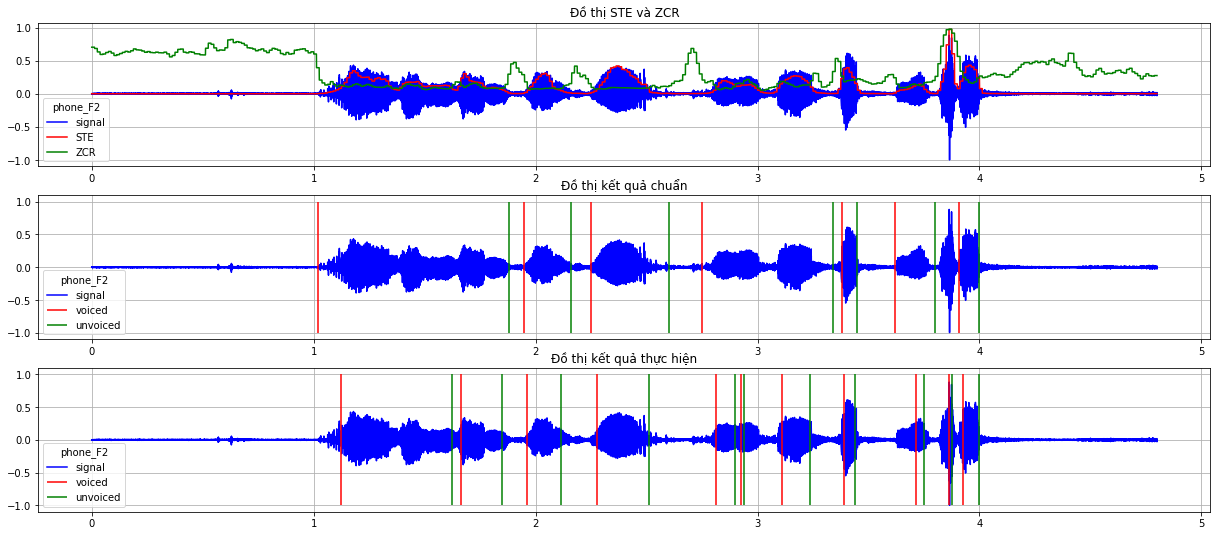

In [53]:

cal_mat("phone_F2",[1.02, 1.95, 2.25, 2.75, 3.38, 3.62, 3.91],[1.88, 2.16, 2.60, 3.34, 3.45, 3.80, 4.00])

phone_M2

C:\Users\dongu\AppData\Local\Temp\ipykernel_10852\3575650828.py:62: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


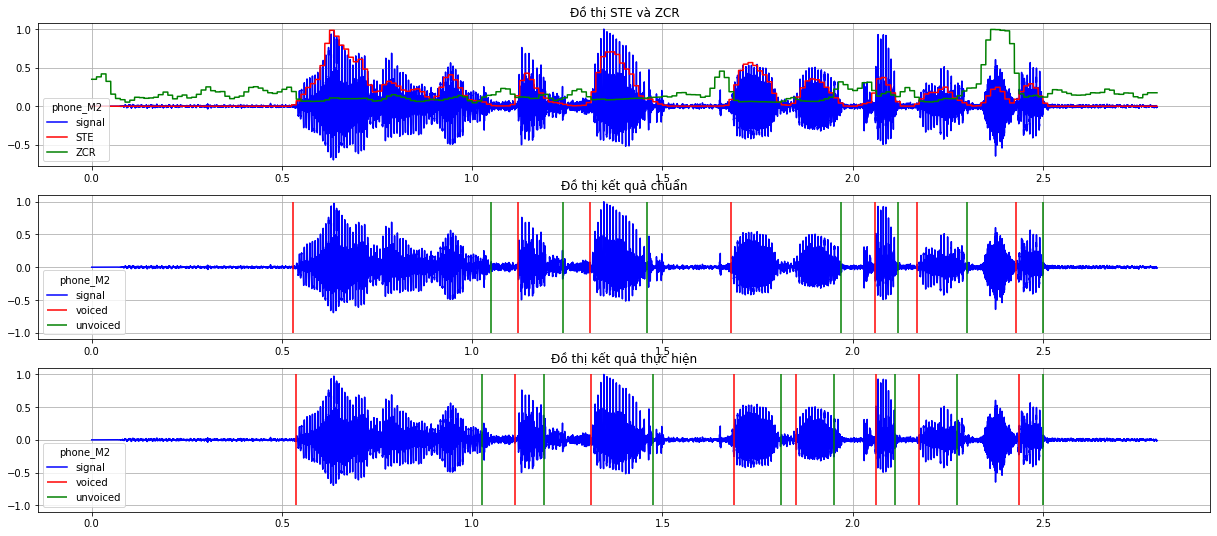

In [54]:
cal_mat("phone_M2",[0.53, 1.12, 1.31, 1.68, 2.06, 2.17, 2.43],[1.05, 1.24, 1.46, 1.97, 2.12, 2.30,2.50])

studio_F2

C:\Users\dongu\AppData\Local\Temp\ipykernel_10852\3575650828.py:62: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


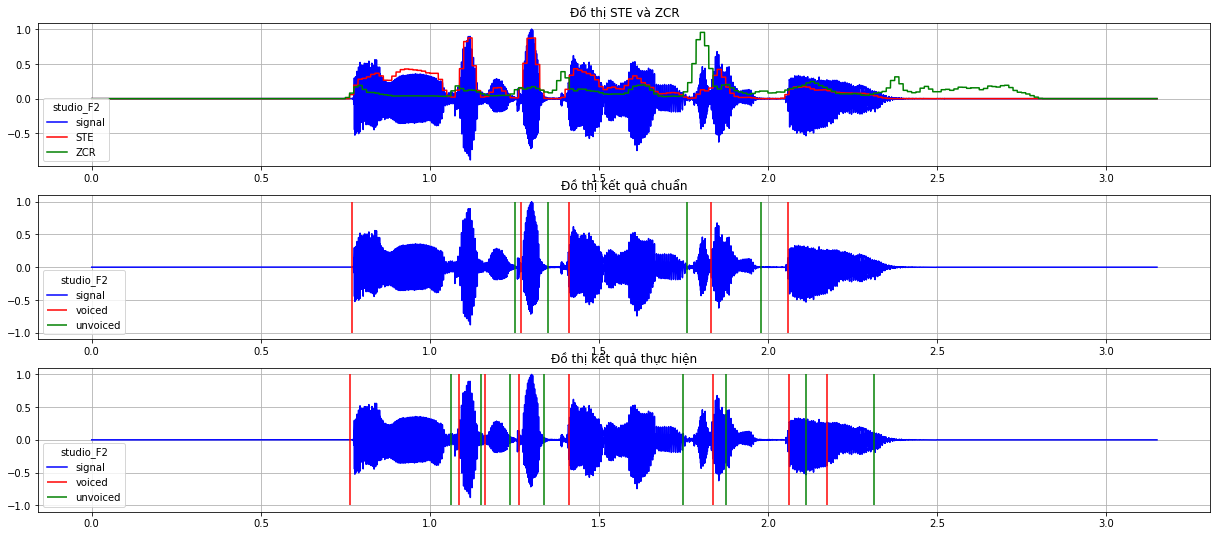

In [55]:
cal_mat("studio_F2",[0.77, 1.27, 1.41, 1.83, 2.06],[1.25, 1.35, 1.76, 1.98])

studio_M2

C:\Users\dongu\AppData\Local\Temp\ipykernel_10852\3575650828.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, x = wavfile.read(file_name_wav + ".wav")
C:\Users\dongu\AppData\Local\Temp\ipykernel_10852\3575650828.py:62: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


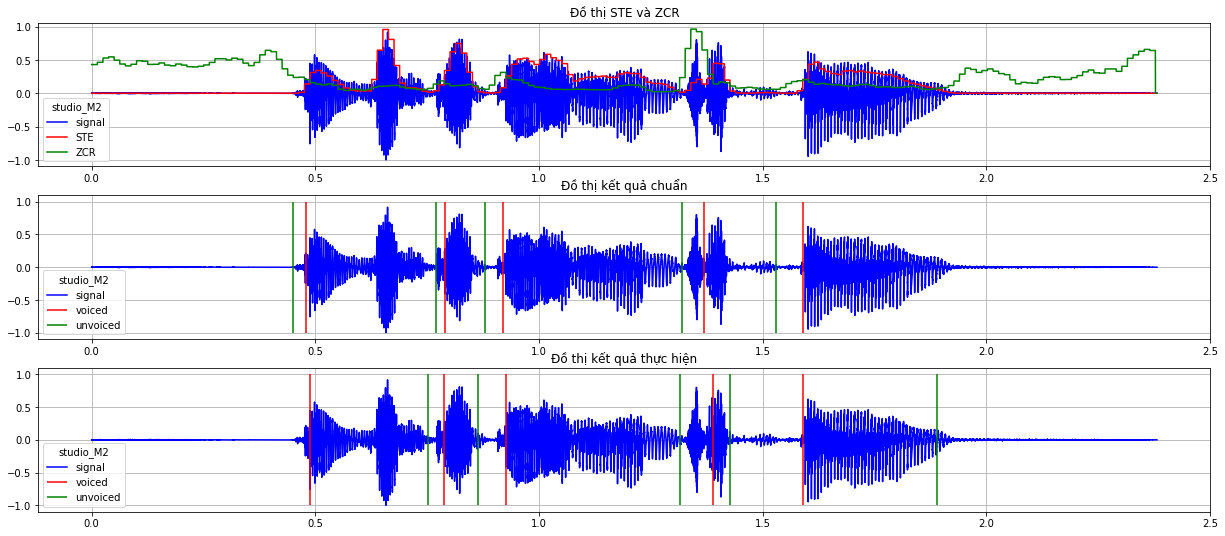

In [56]:
cal_mat("studio_M2",[0.48, 0.79, 0.92, 1.37, 1.59],[0.45, 0.77, 0.88, 1.32, 1.53])